# Predictions for Bitcoin

In [1]:
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestRegressor
from darts import TimeSeries
from datetime import timedelta
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import NaiveDrift, NaiveSeasonal, TCNModel, BlockRNNModel, TransformerModel, TFTModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.graph_objects as go
from darts.metrics import mae, rmse, mse, mape

torch.manual_seed(1)
np.random.seed(1)



c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph(actual, prediction, print_single, model):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = "Bitcoin prices")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [3]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph_backtesting(actual, prediction, print_single, model, horizon):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = f"Backtesting for Bitcoin prices with Forecasting Horizon = {horizon}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [4]:
#retrieve bitcoin data
start_date = '2015-08-01'
end_date = '2019-08-21'

df = yf.download('BTC-USD', interval = '1d', start = start_date, end = end_date)
df = df.drop('Adj Close', axis=1)
df = ta.utils.dropna(df)
df = ta.add_all_ta_features(
    df, "Open", "High", "Low", "Close", "Volume", fillna=True
)
df = df.fillna(0)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [5]:
df

Open          High           Low         Close  \
Date                                                                 
2015-08-01    284.686005    284.932007    278.112000    281.601013   
2015-08-02    280.449005    283.032013    277.528992    282.614014   
2015-08-03    282.806000    285.471008    280.233002    281.226990   
2015-08-04    281.225006    285.714996    281.225006    285.217987   
2015-08-05    284.846985    285.501007    281.488007    281.881989   
...                  ...           ...           ...           ...   
2019-08-16  10319.419922  10524.349609   9855.478516  10374.338867   
2019-08-17  10358.722656  10452.625000  10086.698242  10231.744141   
2019-08-18  10233.005859  10487.070312  10119.094727  10345.810547   
2019-08-19  10350.283203  10916.053711  10313.204102  10916.053711   
2019-08-20  10916.346680  10947.041992  10618.960938  10763.232422   

                 Volume    volume_adi    volume_obv  volume_cmf     volume_fi  \
Date                                                                            
2015-08-01     18995000  4.401154e+05      18995000    0.023170  0.000000e+00   
2015-08-02     17722200  1.547002e+07      36717200    0.421329  1.795260e+07   
2015-08-03     21474100  2.145971e+06      15243100    0.036878  1.113293e+07   
2015-08-04     21908700  1.920440e+07      37151800    0.239755  2.203359e+07   
2015-08-05     20128000  3.028593e+06      17023800    0.030217  9.293509e+06   
...                 ...           ...           ...         ...           ...   
2019-08-16  20228207096  7.446476e+11  816275029159    0.247954 -1.229797e+12   
2019-08-17  13778035685  7.417923e+11  802496993474    0.207125 -1.334780e+12   
2019-08-18  12999813869  7.448113e+11  815496807343    0.237430 -9.322624e+11   
2019-08-19  16038264603  7.608495e+11  831535071946    0.269442  5.074481e+11   
2019-08-20  15053082175  7.590354e+11  816481989771    0.219286  1.063224e+11   

              volume_em  ...  momentum_ppo  momentum_ppo_signal  \
Date                     ...                                      
2015-08-01     0.000000  ...      0.000000             0.000000   
2015-08-02   -38.550550  ...      0.028689             0.005738   
2015-08-03    62.724622  ...      0.011559             0.006902   
2015-08-04    12.665274  ...      0.110940             0.027709   
2015-08-05     0.488578  ...      0.093147             0.040797   
...                 ...  ...           ...                  ...   
2019-08-16   441.600830  ...      0.383770             1.530804   
2019-08-17   211.799172  ...     -0.094474             1.205748   
2019-08-18    94.601929  ...     -0.385764             0.887446   
2019-08-19  1171.047007  ...     -0.185040             0.672949   
2019-08-20   366.967017  ...     -0.139548             0.510449   

            momentum_ppo_hist  momentum_pvo  momentum_pvo_signal  \
Date                                                               
2015-08-01           0.000000      0.000000             0.000000   
2015-08-02           0.022951     -0.537196            -0.107439   
2015-08-03           0.004657      0.625261             0.039101   
2015-08-04           0.083230      1.687835             0.368848   
2015-08-05           0.052350      1.764780             0.648034   
...                       ...           ...                  ...   
2019-08-16          -1.147034     -0.791871            -3.465757   
2019-08-17          -1.300223     -2.949896            -3.362585   
2019-08-18          -1.273210     -5.039784            -3.698025   
2019-08-19          -0.857989     -5.287787            -4.015977   
2019-08-20          -0.649997     -5.893399            -4.391462   

            momentum_pvo_hist  momentum_kama  others_dr  others_dlr  \
Date                                                                  
2015-08-01           0.000000     281.601013   0.000000    0.000000   
2015-08-02          -0.429757     282.100408   0.359729    0.359084   
2015-08-03    

# Feature engineering

In [6]:

split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
X_train = df.iloc[:split_index].drop('Close', axis=1)
y_train = df.iloc[:split_index]['Close']
X_test = df.iloc[split_index:].drop('Close', axis=1)
y_test = df.iloc[split_index:]['Close']

In [7]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [8]:
clf.score(X_test, y_test)

0.986916937518588

In [9]:
features = {k: v for k, v in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)}

In [10]:
features

{'others_cr': 0.35291234695097945,
 'momentum_kama': 0.11779369748098749,
 'Low': 0.09804469911198754,
 'trend_ema_slow': 0.0399912785633635,
 'volatility_bbh': 0.03926869466356652,
 'trend_ichimoku_base': 0.03280301728584682,
 'volatility_kcl': 0.032326782638674334,
 'trend_sma_fast': 0.03196181011225241,
 'volume_adi': 0.03154259280651482,
 'High': 0.0293211411707824,
 'Open': 0.025904841947899167,
 'trend_psar_up': 0.023295537951486128,
 'volume_vpt': 0.023188684105664433,
 'volatility_dch': 0.01708338135453978,
 'trend_ichimoku_conv': 0.01683239837025226,
 'volatility_kcc': 0.016753565312634226,
 'volume_vwap': 0.015927181877954114,
 'volatility_kch': 0.009089808553037365,
 'trend_ichimoku_a': 0.008451679658718417,
 'trend_sma_slow': 0.00824655995099874,
 'trend_ema_fast': 0.007944724035647296,
 'volatility_dcm': 0.0078010727253165916,
 'volume_obv': 0.007612596209939122,
 'volatility_bbm': 0.0018019497367905792,
 'volatility_bbl': 0.0016867538457772647,
 'volatility_dcl': 0.001288

In [11]:
filtered_features = {feature: importance for feature, importance in features.items() if importance >= 0.01}


In [12]:
filtered_features

{'others_cr': 0.35291234695097945,
 'momentum_kama': 0.11779369748098749,
 'Low': 0.09804469911198754,
 'trend_ema_slow': 0.0399912785633635,
 'volatility_bbh': 0.03926869466356652,
 'trend_ichimoku_base': 0.03280301728584682,
 'volatility_kcl': 0.032326782638674334,
 'trend_sma_fast': 0.03196181011225241,
 'volume_adi': 0.03154259280651482,
 'High': 0.0293211411707824,
 'Open': 0.025904841947899167,
 'trend_psar_up': 0.023295537951486128,
 'volume_vpt': 0.023188684105664433,
 'volatility_dch': 0.01708338135453978,
 'trend_ichimoku_conv': 0.01683239837025226,
 'volatility_kcc': 0.016753565312634226,
 'volume_vwap': 0.015927181877954114}

In [13]:
filtered_feature_names = list(filtered_features.keys())
df = df.reset_index()
covs= TimeSeries.from_dataframe(df, time_col="Date", value_cols=filtered_feature_names)
covs = covs.astype(np.float32)
target = TimeSeries.from_dataframe(df, time_col="Date", value_cols=["Close"])
target = target.astype(np.float32)

# Create Train, Validation and Test Set + Past and Future Covariates

In [14]:
#create train and validation series and scale them
test_set_size = 91

split = int((len(df) - test_set_size) * 0.8)

val_set_size = int(len(df) - test_set_size - split)

train_target = target[: -(val_set_size + test_set_size)]

val_target = target[-(val_set_size + test_set_size) : -test_set_size]

test_target = target[-(test_set_size) :]

scaler_target = Scaler()
scaler_features = Scaler()

scaler_target = scaler_target.fit(train_target)


train_scaled = scaler_target.transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

target_scaled = concatenate([train_scaled, val_scaled, test_scaled])

In [15]:
val_set_size

278

Number of components is larger than 10 (17). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


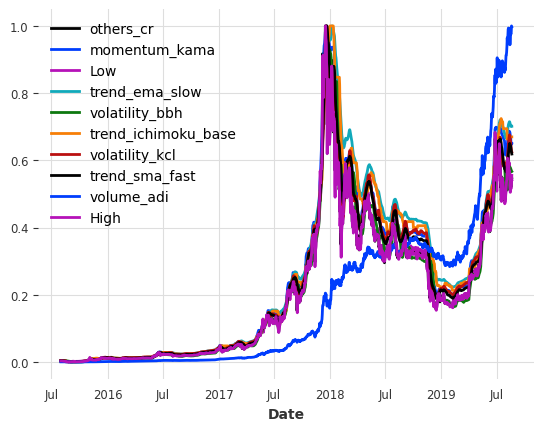

In [16]:
past_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
        covs,
    ],
    axis="component",
)


scaler_ft_past = Scaler()

past_covs = scaler_ft_past.fit_transform(past_covs)
idx = past_covs.columns[6:]
tech_analysis_idx = past_covs[idx.to_list()]
tech_analysis_idx.plot()
plt.show()

In [17]:
future_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
    ],
    axis="component",
)


scaler_ft_future = Scaler()


future_covs = scaler_ft_future.fit_transform(future_covs)

In [18]:
val = scaler_target.inverse_transform(val_scaled)

test = scaler_target.inverse_transform(test_scaled)

# Create csv file where to store all of the Error Metrics

In [19]:
import csv

headers = ['Model', 'MAE', 'RMSE', 'MSE', 'MAPE']
separator = ['-', '-', '-', '-', '-']

with open('./results/error_metrics_BTC.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(headers)

def add_row(row):
  with open('./results/error_metrics_BTC.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

# Naive models

In [20]:
models = {}
predictions = {}

models['naive_drift_model'] = NaiveDrift()
models['naive_model'] = NaiveSeasonal()
models['naive_seasonal_model'] = NaiveSeasonal(7)


for key, model in models.items():
    model.fit(train_scaled)
    predictions[key] = model.predict(len(val_scaled))
    predictions[key] = scaler_target.inverse_transform(predictions[key])

In [21]:
print_graph(val, predictions, False, None)

In [22]:
for key, prediction in predictions.items():
    print(f"MAE of {key}: {mae(val, prediction)}")
    print(f"RMSE of {key}: {rmse(val, prediction)}")
    print(f"MSE of {key}: {mse(val, prediction)}")
    print(f"MAPE of {key}: {mape(val, prediction)}")
    print("\n")
    row = [f'{key}', mae(val, prediction), rmse(val, prediction), mse(val, prediction), mape(val, prediction) ]
    add_row(row)

add_row(separator)

MAE of naive_drift_model: 2073.65966796875
RMSE of naive_drift_model: 2536.091796875
MSE of naive_drift_model: 6431761.5
MAPE of naive_drift_model: 51.087671518325806


MAE of naive_model: 1486.890380859375
RMSE of naive_model: 1830.1337890625
MSE of naive_model: 3349389.75
MAPE of naive_model: 36.67953312397003


MAE of naive_seasonal_model: 1470.3406982421875
RMSE of naive_seasonal_model: 1793.189697265625
MSE of naive_seasonal_model: 3215529.25
MAPE of naive_seasonal_model: 36.08761727809906




# Backtesting Naive Drift Model

In [23]:
bt_horizons = [1, 7 ,30]
bt_start=test_target.time_index[0]


In [24]:
backtesting_Drift = []
backtesting_Naive = []
backtesting_NaiveSeasonal = []
backtesting_ExpSmoothing = []
backtesting_Arima = []
backtesting_Prophet = []
backtesting_Tbats = []

In [25]:

for h in bt_horizons:
  hist_Drift = models['naive_drift_model'].historical_forecasts(
          target_scaled,
          start= bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Drift = scaler_target.inverse_transform(hist_Drift)
  backtesting_Drift.append(hist_predict_Drift)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [26]:
len(backtesting_Drift)

3

In [27]:
for b in backtesting_Drift:
  h = bt_horizons[backtesting_Drift.index(b)]
  print_graph_backtesting(test, b, True, 'naive_drift_model',h)

In [28]:
add_row(['Backtesting Naive Drift Model','','','',''])
for b in backtesting_Drift:
  print(f"MAE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Drift fh={bt_horizons[backtesting_Drift.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Drift Model forecasting horizon = 1: 372.4648742675781
RMSE of Naive Drift Model forecasting horizon = 1: 512.7448120117188
MSE of Naive Drift Model forecasting horizon = 1: 262907.21875
MAPE of Naive Drift Model forecasting horizon = 1: 3.583085536956787


MAE of Naive Drift Model forecasting horizon = 7: 980.3724365234375
RMSE of Naive Drift Model forecasting horizon = 7: 1205.1668701171875
MSE of Naive Drift Model forecasting horizon = 7: 1452427.125
MAPE of Naive Drift Model forecasting horizon = 7: 9.557130932807922


MAE of Naive Drift Model forecasting horizon = 30: 1811.1964111328125
RMSE of Naive Drift Model forecasting horizon = 30: 2180.213134765625
MSE of Naive Drift Model forecasting horizon = 30: 4753329.0
MAPE of Naive Drift Model forecasting horizon = 30: 18.172332644462585




# Backtesting Naive Model

In [29]:
for h in bt_horizons:
  hist_Naive = models['naive_model'].historical_forecasts(
          target_scaled,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Naive = scaler_target.inverse_transform(hist_Naive)
  backtesting_Naive.append(hist_predict_Naive)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

In [30]:
for b in backtesting_Naive:
  h = bt_horizons[backtesting_Naive.index(b)]
  print_graph_backtesting(test, b, True, 'naive_model',h)

In [31]:
add_row(['Backtesting Naive Model','','','',''])
for b in backtesting_Naive:
  print(f"MAE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive fh={bt_horizons[backtesting_Naive.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Model forecasting horizon = 1: 373.26226806640625
RMSE of Naive Model forecasting horizon = 1: 512.9063720703125
MSE of Naive Model forecasting horizon = 1: 263072.9375
MAPE of Naive Model forecasting horizon = 1: 3.5903453826904297


MAE of Naive Model forecasting horizon = 7: 983.3944091796875
RMSE of Naive Model forecasting horizon = 7: 1208.596923828125
MSE of Naive Model forecasting horizon = 7: 1460706.625
MAPE of Naive Model forecasting horizon = 7: 9.576305001974106


MAE of Naive Model forecasting horizon = 30: 1864.664794921875
RMSE of Naive Model forecasting horizon = 30: 2258.376220703125
MSE of Naive Model forecasting horizon = 30: 5100263.5
MAPE of Naive Model forecasting horizon = 30: 18.750570714473724




# Backtesting Naive Seasonal Model

In [32]:
for h in bt_horizons:
  hist_NaiveSeasonal = models['naive_seasonal_model'].historical_forecasts(
          target_scaled,
          start = bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_NaiveSeasonal = scaler_target.inverse_transform(hist_NaiveSeasonal)
  backtesting_NaiveSeasonal.append(hist_predict_NaiveSeasonal)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

In [33]:
for b in backtesting_NaiveSeasonal:
  h = bt_horizons[backtesting_NaiveSeasonal.index(b)]
  print_graph_backtesting(test, b, True, 'naive_seasonal_model',h)

In [34]:
add_row(['Backtesting Naive Seasonal Model','','','',''])
for b in backtesting_NaiveSeasonal:
  print(f"MAE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Seasonal fh={bt_horizons[backtesting_NaiveSeasonal.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Seasonal Model forecasting horizon = 1: 983.3944091796875
RMSE of Naive Seasonal Model forecasting horizon = 1: 1208.596923828125
MSE of Naive Seasonal Model forecasting horizon = 1: 1460706.625
MAPE of Naive Seasonal Model forecasting horizon = 1: 9.576305001974106


MAE of Naive Seasonal Model forecasting horizon = 7: 1014.5049438476562
RMSE of Naive Seasonal Model forecasting horizon = 7: 1240.08154296875
MSE of Naive Seasonal Model forecasting horizon = 7: 1537802.125
MAPE of Naive Seasonal Model forecasting horizon = 7: 9.78739783167839


MAE of Naive Seasonal Model forecasting horizon = 30: 2005.4776611328125
RMSE of Naive Seasonal Model forecasting horizon = 30: 2396.065673828125
MSE of Naive Seasonal Model forecasting horizon = 30: 5741130.5
MAPE of Naive Seasonal Model forecasting horizon = 30: 18.11463236808777




# Graphs of the Naive Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [35]:
predictions_naive_1= {}
predictions_naive_7= {}
predictions_naive_30= {}

naive_models = ['Naive', 'Naive Drift', 'Naive Seasonal']
backtesting_naive =[backtesting_Naive, backtesting_Drift, backtesting_NaiveSeasonal]
predictions_naive = [predictions_naive_1, predictions_naive_7, predictions_naive_30]

for i in predictions_naive:
    for j in naive_models:
        i[j] = backtesting_naive[naive_models.index(j)][predictions_naive.index(i)]

In [36]:
#print

print_graph_backtesting(test, predictions_naive_1, False, None, 1)
print_graph_backtesting(test, predictions_naive_7, False, None, 7)
print_graph_backtesting(test, predictions_naive_30, False, None, 30)


# Random Forest

In [37]:
from darts.models import RandomForest

random_forest_model = RandomForest(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    n_estimators=100,  # Number of trees in the forest
    max_depth=15,  # Maximum depth of each tree
)

In [38]:
random_forest_model.fit(train_scaled, past_covariates = past_covs)
random_forest_prediction = random_forest_model.predict(n = len(val_scaled))
random_forest_prediction = scaler_target.inverse_transform(random_forest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [39]:
print_graph(val, random_forest_prediction, True, 'Random Forest')

In [40]:
print(f"MAE of Random Forest: {mae(val, random_forest_prediction)}")
print(f"RMSE of Random Forest: {rmse(val, random_forest_prediction)}")
print(f"MSE of Random Forest: {mse(val, random_forest_prediction)}")
print(f"MAPE of Random Forest: {mape(val, random_forest_prediction)}")
row = ['Random Forest', mae(val, random_forest_prediction), rmse(val, random_forest_prediction), mse(val, random_forest_prediction), mape(val, random_forest_prediction) ]
add_row(row)
add_row(separator)

MAE of Random Forest: 563.0467866280754
RMSE of Random Forest: 750.57956657093
MSE of Random Forest: 563369.6857538051
MAPE of Random Forest: 13.611385192635241


# Backtesting Random Forest

In [41]:
backtesting_RF = []

bt_horizons = [1, 7 ,30]

bt_start=test.time_index[0]

for h in bt_horizons:

  hist_RF = random_forest_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_RF = scaler_target.inverse_transform(hist_RF)
  backtesting_RF.append(hist_predict_RF)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/91 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/91 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [42]:
for b in backtesting_RF:
  h = bt_horizons[backtesting_RF.index(b)]
  print_graph_backtesting(test, b, True, 'Random Forest',h)

In [43]:
add_row(['Backtesting Random Forest','','','',''])
for b in backtesting_RF:
  print(f"MAE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Random Forest fh={bt_horizons[backtesting_RF.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RF forecasting horizon = 1: 494.1782969692266
RMSE of RF forecasting horizon = 1: 628.8679730717325
MSE of RF forecasting horizon = 1: 395474.92755534936
MAPE of RF forecasting horizon = 1: 4.766780866904782


MAE of RF forecasting horizon = 7: 657.6644822047288
RMSE of RF forecasting horizon = 7: 805.7236216629215
MSE of RF forecasting horizon = 7: 649190.5545056146
MAPE of RF forecasting horizon = 7: 6.250211037088796


MAE of RF forecasting horizon = 30: 670.7789448366226
RMSE of RF forecasting horizon = 30: 815.8698096515121
MSE of RF forecasting horizon = 30: 665643.5463007946
MAPE of RF forecasting horizon = 30: 6.3655825703364




# LSTM Model

Best parameters: {'hidden_dim': 104,
 'r_rnn_layers': 4,
 'dropout': 0.18390991552139796,
 'lr': 0.00014678997505613995,
 'encoders': False}

In [45]:
LSTM_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_dim=43,
    model='LSTM',
    n_rnn_layers=3,
    dropout= 0.28657130197081176,
    optimizer_kwargs={'lr':0.00048112733032723944},
)

In [46]:
LSTM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 42.1 K
4 | fc            | Sequential       | 308   
---------------------------------------------------
42.4 K    Trainable params
0         Non-trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=LSTM, hidden_dim=43, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.28657130197081176, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00048112733032723944})

In [47]:
LSTM_model_prediction = LSTM_model.predict(n = len(val_scaled))
LSTM_model_prediction = scaler_target.inverse_transform(LSTM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [48]:
print_graph(val, LSTM_model_prediction, True, 'LSTM model')

In [49]:
print(f"MAE of LSTM: {mae(val, LSTM_model_prediction)}")
print(f"RMSE of LSTM: {rmse(val, LSTM_model_prediction)}")
print(f"MSE of LSTM: {mse(val, LSTM_model_prediction)}")
print(f"MAPE of LSTM: {mape(val, LSTM_model_prediction)}")
row = ['LSTM', mae(val, LSTM_model_prediction), rmse(val, LSTM_model_prediction), mse(val, LSTM_model_prediction), mape(val, LSTM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LSTM: 793.8128662109375
RMSE of LSTM: 937.869384765625
MSE of LSTM: 879599.0
MAPE of LSTM: 18.518197536468506


# Backtesting LSTM

In [50]:
backtesting_LSTM = []

for h in bt_horizons:

  hist_LSTM = LSTM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_LSTM = scaler_target.inverse_transform(hist_LSTM)
  backtesting_LSTM.append(hist_predict_LSTM)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
for b in backtesting_LSTM:
  h = bt_horizons[backtesting_LSTM.index(b)]
  print_graph_backtesting(test, b, True, 'LSTM model',h)

In [52]:
add_row(['Backtesting LSTM Model','','','',''])
for b in backtesting_LSTM:
  print(f"MAE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LSTM fh={bt_horizons[backtesting_LSTM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of LSTM forecasting horizon = 1: 1066.6673583984375
RMSE of LSTM forecasting horizon = 1: 1358.2745361328125
MSE of LSTM forecasting horizon = 1: 1844909.75
MAPE of LSTM forecasting horizon = 1: 9.872392565011978


MAE of LSTM forecasting horizon = 7: 2079.84619140625
RMSE of LSTM forecasting horizon = 7: 2421.484619140625
MSE of LSTM forecasting horizon = 7: 5863588.0
MAPE of LSTM forecasting horizon = 7: 19.46624517440796


MAE of LSTM forecasting horizon = 30: 2132.034912109375
RMSE of LSTM forecasting horizon = 30: 2480.58984375
MSE of LSTM forecasting horizon = 30: 6153325.5
MAPE of LSTM forecasting horizon = 30: 19.939035177230835




# VanillaRNN Model

Best parameters:
{'hidden_dim': 31,
 'n_rnn_layers': 1,
 'dropout': 0.34008569567908437,
 'lr': 0.0009241588491743642,
 'encoders': False}

In [53]:
vanillaRNN_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='RNN',
    hidden_dim=46,
    n_rnn_layers=3,
    dropout=0.02622050492850875,
    optimizer_kwargs={'lr': 0.0009977736177203696},
)

In [54]:
vanillaRNN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 12.0 K
4 | fc            | Sequential       | 329   
---------------------------------------------------
12.3 K    Trainable params
0         Non-trainable params
12.3 K    Total params
0.049     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=RNN, hidden_dim=46, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.02622050492850875, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0009977736177203696})

In [55]:
vanillaRNN_model_prediction = vanillaRNN_model.predict(n = len(val_scaled))
vanillaRNN_model_prediction = scaler_target.inverse_transform(vanillaRNN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [56]:
print_graph(val, vanillaRNN_model_prediction, True, 'Vanilla RNN')

In [57]:
print(f"MAE of VanillaRNN: {mae(val, vanillaRNN_model_prediction)}")
print(f"RMSE of VanillaRNN: {rmse(val, vanillaRNN_model_prediction)}")
print(f"MSE of VanillaRNN: {mse(val, vanillaRNN_model_prediction)}")
print(f"MAPE of VanillaRNN: {mape(val, vanillaRNN_model_prediction)}")
row = ['VanillaRNN', mae(val, vanillaRNN_model_prediction), rmse(val, vanillaRNN_model_prediction), mse(val, vanillaRNN_model_prediction), mape(val, vanillaRNN_model_prediction)]
add_row(row)
add_row(separator)

MAE of VanillaRNN: 356.3705139160156
RMSE of VanillaRNN: 471.7834777832031
MSE of VanillaRNN: 222579.65625
MAPE of VanillaRNN: 7.564099133014679


# Backtesting VanillaRNN

In [58]:
backtesting_VanillaRNN = []

for h in bt_horizons:

  hist_VanillaRNN = vanillaRNN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_VanillaRNN = scaler_target.inverse_transform(hist_VanillaRNN)
  backtesting_VanillaRNN.append(hist_predict_VanillaRNN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [59]:
for b in backtesting_VanillaRNN:
  h = bt_horizons[backtesting_VanillaRNN.index(b)]
  print_graph_backtesting(test, b, True, 'Vanilla RNN',h)

In [60]:
add_row(['Backtesting RNN Model','','','',''])
for b in backtesting_VanillaRNN:
  print(f"MAE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'RNN fh={bt_horizons[backtesting_VanillaRNN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RNN forecasting horizon = 1: 936.6631469726562
RMSE of RNN forecasting horizon = 1: 1075.844482421875
MSE of RNN forecasting horizon = 1: 1157441.375
MAPE of RNN forecasting horizon = 1: 9.82249230146408


MAE of RNN forecasting horizon = 7: 2188.94970703125
RMSE of RNN forecasting horizon = 7: 2523.005615234375
MSE of RNN forecasting horizon = 7: 6365557.5
MAPE of RNN forecasting horizon = 7: 20.640625059604645


MAE of RNN forecasting horizon = 30: 2085.0673828125
RMSE of RNN forecasting horizon = 30: 2441.7451171875
MSE of RNN forecasting horizon = 30: 5962119.5
MAPE of RNN forecasting horizon = 30: 19.514507055282593




# GRU Model

Best parameters: {'hidden_dim': 75,
 'r_rnn_layers': 1,
 'dropout': 0.007824503730612165,
 'lr': 0.000566687831423731,
 'encoders': False}

In [61]:
GRU_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='GRU',
    hidden_dim=153,
    n_rnn_layers=1,
    dropout=0.0707239073983959,
    optimizer_kwargs={'lr': 2.3436557068849167e-05},
)

In [62]:
GRU_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0707239073983959 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 82.2 K
4 | fc            | Sequential       | 1.1 K 
---------------------------------------------------
83.2 K    Trainable params
0         Non-trainable params
83.2 K    Total params
0.333     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=GRU, hidden_dim=153, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0707239073983959, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 2.3436557068849167e-05})

In [63]:
GRU_model_prediction = GRU_model.predict(n = len(val_scaled))
GRU_model_prediction = scaler_target.inverse_transform(GRU_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [64]:
print_graph(val, GRU_model_prediction, True, 'GRU Model')

In [65]:
print(f"MAE of GRU: {mae(val, GRU_model_prediction)}")
print(f"RMSE of GRU: {rmse(val, GRU_model_prediction)}")
print(f"MSE of GRU: {mse(val, GRU_model_prediction)}")
print(f"MAPE of GRU: {mape(val, GRU_model_prediction)}")
row = ['GRU Model', mae(val, GRU_model_prediction), rmse(val, GRU_model_prediction), mse(val, GRU_model_prediction), mape(val, GRU_model_prediction) ]
add_row(row)
add_row(separator)

MAE of GRU: 626.4910888671875
RMSE of GRU: 830.3692016601562
MSE of GRU: 689513.0
MAPE of GRU: 12.86342740058899


# Backtesting GRU

In [66]:
backtesting_GRU = []

for h in bt_horizons:

  hist_GRU = GRU_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_GRU = scaler_target.inverse_transform(hist_GRU)
  backtesting_GRU.append(hist_predict_GRU)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [67]:
for b in backtesting_GRU:
  h = bt_horizons[backtesting_GRU.index(b)]
  print_graph_backtesting(test, b, True, 'GRU model',h)

In [68]:
add_row(['Backtesting GRU Model','','','',''])
for b in backtesting_GRU:
  print(f"MAE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mae(test, b)}")
  print(f"RMSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {rmse(test, b)}")
  print(f"MSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mse(test, b)}")
  print(f"MAPE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'GRU fh={bt_horizons[backtesting_GRU.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of GRU forecasting horizon = 1: 613.813720703125
RMSE of GRU forecasting horizon = 1: 781.6962890625
MSE of GRU forecasting horizon = 1: 611049.0625
MAPE of GRU forecasting horizon = 1: 5.98384402692318


MAE of GRU forecasting horizon = 7: 961.4336547851562
RMSE of GRU forecasting horizon = 7: 1238.694580078125
MSE of GRU forecasting horizon = 7: 1534364.125
MAPE of GRU forecasting horizon = 7: 9.196776896715164


MAE of GRU forecasting horizon = 30: 969.0886840820312
RMSE of GRU forecasting horizon = 30: 1247.718017578125
MSE of GRU forecasting horizon = 30: 1556800.375
MAPE of GRU forecasting horizon = 30: 9.272917360067368




# Transformer Model

Best params: {'d_model': 88, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dropout': 0.14295488378943239, 'lr': 0.00046254166100837376, 'encoders': False}

In [69]:
transformer_model = TransformerModel(
    input_chunk_length = 21,
    output_chunk_length = 7,
    d_model=92,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=4,
    dropout=0.11249672199493155,
    optimizer_kwargs={'lr': 0.0002891919462695517},
)

In [70]:
transformer_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 2.3 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 914 K 
6 | decoder             | Linear              | 651   
------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TransformerModel(d_model=92, nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=512, dropout=0.11249672199493155, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0002891919462695517})

In [71]:
transformer_model_prediction = transformer_model.predict(n = len(val_scaled))
transformer_model_prediction = scaler_target.inverse_transform(transformer_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [72]:
print_graph(val, transformer_model_prediction, True, 'Transformer Model')

In [73]:
print(f"MAE of Transformer Model: {mae(val, transformer_model_prediction)}")
print(f"RMSE of Transformer Model: {rmse(val, transformer_model_prediction)}")
print(f"MSE of Transformer Model: {mse(val, transformer_model_prediction)}")
print(f"MAPE of Transformer Model: {mape(val, transformer_model_prediction)}")
row = ['Transformer Model', mae(val, transformer_model_prediction), rmse(val, transformer_model_prediction), mse(val, transformer_model_prediction), mape(val, transformer_model_prediction) ]
add_row(row)
add_row(separator)

MAE of Transformer Model: 1168.4832763671875
RMSE of Transformer Model: 1386.6434326171875
MSE of Transformer Model: 1922780.0
MAPE of Transformer Model: 27.851736545562744


# Backtesting Transformer Model

In [74]:
backtesting_Transformer = []

for h in bt_horizons:

  hist_Transformer = transformer_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_Transformer = scaler_target.inverse_transform(hist_Transformer)
  backtesting_Transformer.append(hist_predict_Transformer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [75]:
for b in backtesting_Transformer:
  h = bt_horizons[backtesting_Transformer.index(b)]
  print_graph_backtesting(test, b, True, 'Transformer Model',h)

In [76]:
add_row(['Backtesting Transformer Model','','','',''])
for b in backtesting_Transformer:
  print(f"MAE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Transformer fh={bt_horizons[backtesting_Transformer.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Transformer Model forecasting horizon = 1: 1000.7949829101562
RMSE of Transformer Model forecasting horizon = 1: 1235.21923828125
MSE of Transformer Model forecasting horizon = 1: 1525766.5
MAPE of Transformer Model forecasting horizon = 1: 9.502864629030228


MAE of Transformer Model forecasting horizon = 7: 1432.2484130859375
RMSE of Transformer Model forecasting horizon = 7: 1746.0718994140625
MSE of Transformer Model forecasting horizon = 7: 3048767.25
MAPE of Transformer Model forecasting horizon = 7: 13.665373623371124


MAE of Transformer Model forecasting horizon = 30: 1591.7247314453125
RMSE of Transformer Model forecasting horizon = 30: 1889.5445556640625
MSE of Transformer Model forecasting horizon = 30: 3570378.5
MAPE of Transformer Model forecasting horizon = 30: 15.190060436725616




# TFT Model

best parameters: {'hidden_size': 30,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.06118422728497173,
 'hidden_continuous_size': 10,
 'lr': 0.005081664304452033}

In [77]:
TFT_model = TFTModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=2,
    dropout=0.17226530732530446,
    hidden_continuous_size=9,
    optimizer_kwargs={'lr': 0.008671478870787766},
)

In [78]:
TFT_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    future_covariates = future_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 42.0 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 6.7 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.17226530732530446, hidden_continuous_size=9, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.008671478870787766})

In [79]:
TFT_model_prediction = TFT_model.predict(n = len(val_scaled))
TFT_model_prediction = scaler_target.inverse_transform(TFT_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [80]:
print_graph(val, TFT_model_prediction, True, 'TFT Model')

In [81]:
print(f"MAE of TFT Model: {mae(val, TFT_model_prediction)}")
print(f"RMSE of TFT Model: {rmse(val, TFT_model_prediction)}")
print(f"MSE of TFT Model: {mse(val, TFT_model_prediction)}")
print(f"MAPE of TFT Model: {mape(val, TFT_model_prediction)}")
row = ['TFT', mae(val, TFT_model_prediction), rmse(val, TFT_model_prediction), mse(val, TFT_model_prediction), mape(val, TFT_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TFT Model: 1749.7650146484375
RMSE of TFT Model: 1983.831298828125
MSE of TFT Model: 3935586.5
MAPE of TFT Model: 40.157514810562134


# Backtesting TFT Model

In [82]:
backtesting_TFT = []

for h in bt_horizons:

  hist_TFT = TFT_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          future_covariates = future_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TFT = scaler_target.inverse_transform(hist_TFT)
  backtesting_TFT.append(hist_predict_TFT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [83]:
for b in backtesting_TFT:
  h = bt_horizons[backtesting_TFT.index(b)]
  print_graph_backtesting(test, b, True, 'TFT Model',h)

In [84]:
add_row(['Backtesting TFT Model','','','',''])
for b in backtesting_TFT:
  print(f"MAE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TFT fh={bt_horizons[backtesting_TFT.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TFT Model forecasting horizon = 1: 1253.634033203125
RMSE of TFT Model forecasting horizon = 1: 1636.608154296875
MSE of TFT Model forecasting horizon = 1: 2678486.25
MAPE of TFT Model forecasting horizon = 1: 12.12352067232132


MAE of TFT Model forecasting horizon = 7: 1507.204345703125
RMSE of TFT Model forecasting horizon = 7: 1938.7720947265625
MSE of TFT Model forecasting horizon = 7: 3758837.0
MAPE of TFT Model forecasting horizon = 7: 14.691586792469025


MAE of TFT Model forecasting horizon = 30: 1441.2745361328125
RMSE of TFT Model forecasting horizon = 30: 1781.1416015625
MSE of TFT Model forecasting horizon = 30: 3172465.25
MAPE of TFT Model forecasting horizon = 30: 14.00129646062851




# NBEATS Model

Best parameters: {'num_stacks': 19,
 'num_blocks': 4,
 'num_layers': 4,
 'layer_widths': 378,
 'expansion_coefficient_dim': 8,
 'dropout': 0.007293860107310261,
 'lr': 0.0005903374698873167,
 'encoders': True}

In [85]:
from darts.models import NBEATSModel

NBEATS_model = NBEATSModel(
    input_chunk_length=21,
    output_chunk_length=7,
    num_stacks=16,
    num_blocks=5,
    num_layers=3,
    layer_widths=386,
    expansion_coefficient_dim=10,
    dropout=0.019877849352538418,
    optimizer_kwargs={'lr': 6.135769404419855e-05},
    
)

In [86]:

NBEATS_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 40.7 M
---------------------------------------------------
40.7 M    Trainable params
9.4 K     Non-trainable params
40.7 M    Total params
162.824   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=16, num_blocks=5, num_layers=3, layer_widths=386, expansion_coefficient_dim=10, trend_polynomial_degree=2, dropout=0.019877849352538418, activation=ReLU, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 6.135769404419855e-05})

In [87]:
NBEATS_model_prediction = NBEATS_model.predict(n=len(val_scaled))
NBEATS_model_prediction = scaler_target.inverse_transform(NBEATS_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [88]:
print_graph(val, NBEATS_model_prediction, True, 'NBEATS Model')

In [89]:
print(f"MAE of NBEATS: {mae(val, NBEATS_model_prediction)}")
print(f"RMSE of NBEATS: {rmse(val, NBEATS_model_prediction)}")
print(f"MSE of NBEATS: {mse(val, NBEATS_model_prediction)}")
print(f"MAPE of NBEATS: {mape(val, NBEATS_model_prediction)}")
row = ['NBEATS', mae(val, NBEATS_model_prediction), rmse(val, NBEATS_model_prediction), mse(val, NBEATS_model_prediction), mape(val, NBEATS_model_prediction) ]
add_row(row)
add_row(separator)

MAE of NBEATS: 1183.8182373046875
RMSE of NBEATS: 1386.42724609375
MSE of NBEATS: 1922180.625
MAPE of NBEATS: 27.39790678024292


# Backtesting NBEATS Model

In [90]:
backtesting_NBEATS = []

for h in bt_horizons:

  hist_NBEATS = NBEATS_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_NBEATS = scaler_target.inverse_transform(hist_NBEATS)
  backtesting_NBEATS.append(hist_predict_NBEATS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [91]:
for b in backtesting_NBEATS:
  h = bt_horizons[backtesting_NBEATS.index(b)]
  print_graph_backtesting(test, b, True, 'NBEATS Model',h)

In [92]:
add_row(['Backtesting NBEATS Model','','','',''])
for b in backtesting_NBEATS:
  print(f"MAE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mae(test, b)}")
  print(f"RMSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {rmse(test, b)}")
  print(f"MSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mse(test, b)}")
  print(f"MAPE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'NBEATS fh={bt_horizons[backtesting_NBEATS.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of NBEATS Model forecasting horizon = 1: 920.3933715820312
RMSE of NBEATS Model forecasting horizon = 1: 1091.849853515625
MSE of NBEATS Model forecasting horizon = 1: 1192136.125
MAPE of NBEATS Model forecasting horizon = 1: 9.645583480596542


MAE of NBEATS Model forecasting horizon = 7: 1428.1859130859375
RMSE of NBEATS Model forecasting horizon = 7: 1779.1143798828125
MSE of NBEATS Model forecasting horizon = 7: 3165248.0
MAPE of NBEATS Model forecasting horizon = 7: 13.400553166866302


MAE of NBEATS Model forecasting horizon = 30: 1509.4700927734375
RMSE of NBEATS Model forecasting horizon = 30: 1833.9798583984375
MSE of NBEATS Model forecasting horizon = 30: 3363482.0
MAPE of NBEATS Model forecasting horizon = 30: 14.18180763721466




# TCN Model

Best parameters: {'kernel_size': 8,
 'num_filters': 36,
 'weight_norm': False,
 'dilation_base': 2,
 'dropout': 0.14321708644925318,
 'lr': 0.0005056311276120884,
 'encoders': True}

In [93]:
TCN_model = TCNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    kernel_size=6,
    num_filters=37,
    weight_norm= False,
    dilation_base=4,
    dropout= 0.32368512619895207,
    optimizer_kwargs={'lr': 0.00019964545385002666},
    random_state=0,
)

In [94]:
TCN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 23.1 K
----------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=6, num_filters=37, num_layers=None, dilation_base=4, weight_norm=False, dropout=0.32368512619895207, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00019964545385002666}, random_state=0)

In [95]:
TCN_model_prediction = TCN_model.predict(n = len(val_scaled))
TCN_model_prediction = scaler_target.inverse_transform(TCN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [96]:
print_graph(val, TCN_model_prediction, True, 'TCN Model')

In [97]:
print(f"MAE of TCN: {mae(val, TCN_model_prediction)}")
print(f"RMSE of TCN: {rmse(val, TCN_model_prediction)}")
print(f"MSE of TCN: {mse(val, TCN_model_prediction)}")
print(f"MAPE of TCN: {mape(val, TCN_model_prediction)}")
row = ['TCN', mae(val, TCN_model_prediction), rmse(val, TCN_model_prediction), mse(val, TCN_model_prediction), mape(val, TCN_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TCN: 611.8611450195312
RMSE of TCN: 784.6937255859375
MSE of TCN: 615744.25
MAPE of TCN: 13.413108885288239


# Backtesting TCN Model

In [98]:
backtesting_TCN = []

for h in bt_horizons:

  hist_TCN = TCN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TCN = scaler_target.inverse_transform(hist_TCN)
  backtesting_TCN.append(hist_predict_TCN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [99]:
for b in backtesting_TCN:
  h = bt_horizons[backtesting_TCN.index(b)]
  print_graph_backtesting(test, b, True, 'TCN Model',h)

In [100]:
add_row(['Backtesting TCN Model','','','',''])
for b in backtesting_TCN:
  print(f"MAE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TCN fh={bt_horizons[backtesting_TCN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TCN Model forecasting horizon = 1: 1897.9346923828125
RMSE of TCN Model forecasting horizon = 1: 2197.98291015625
MSE of TCN Model forecasting horizon = 1: 4831128.5
MAPE of TCN Model forecasting horizon = 1: 17.971839010715485


MAE of TCN Model forecasting horizon = 7: 2313.33544921875
RMSE of TCN Model forecasting horizon = 7: 2584.822509765625
MSE of TCN Model forecasting horizon = 7: 6681307.5
MAPE of TCN Model forecasting horizon = 7: 22.087879478931427


MAE of TCN Model forecasting horizon = 30: 2326.529052734375
RMSE of TCN Model forecasting horizon = 30: 2596.416748046875
MSE of TCN Model forecasting horizon = 30: 6741379.5
MAPE of TCN Model forecasting horizon = 30: 22.219498455524445




# Graphs of the DL Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [101]:
predictions_DL_1= {}
predictions_DL_7= {}
predictions_DL_30= {}

DL_models = ['LSTM', 'RNN', 'GRU', 'Transformer', 'TFT', 'NBEATS', 'TCN']
backtesting_DL =[backtesting_LSTM, backtesting_VanillaRNN, backtesting_GRU, backtesting_Transformer, backtesting_TFT, backtesting_NBEATS, backtesting_TCN] 
predictions_DL = [predictions_DL_1, predictions_DL_7, predictions_DL_30]

for i in predictions_DL:
    for j in DL_models:
        i[j] = backtesting_DL[DL_models.index(j)][predictions_DL.index(i)]

In [102]:
print_graph_backtesting(test, predictions_DL_1, False, None, 1)
print_graph_backtesting(test, predictions_DL_7, False, None, 7)
print_graph_backtesting(test, predictions_DL_30, False, None, 30)

# LightGBM Model

In [103]:
from darts.models.forecasting.lgbm import LightGBMModel

LightGBM_model = LightGBMModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [104]:
LightGBM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,

)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157609
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 768
[LightGBM] [Info] Start training from score 0.191105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157609
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 768
[LightGBM] [Info] Start training from score 0.191436
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157609
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 768
[LightGBM] [Info] Start 

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [105]:
LightGBM_model_prediction = LightGBM_model.predict(n = len(val_scaled))
LightGBM_model_prediction = scaler_target.inverse_transform(LightGBM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [106]:
print_graph(val, LightGBM_model_prediction,True, 'LightGBM Model')

In [107]:
print(f"MAE of LightGBM: {mae(val, LightGBM_model_prediction)}")
print(f"RMSE of LightGBM: {rmse(val, LightGBM_model_prediction)}")
print(f"MSE of LightGBM: {mse(val, LightGBM_model_prediction)}")
print(f"MAPE of LightGBM: {mape(val, LightGBM_model_prediction)}")
row = ['LightGBM', mae(val, LightGBM_model_prediction), rmse(val, LightGBM_model_prediction), mse(val, LightGBM_model_prediction), mape(val, LightGBM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LightGBM: 2336.6040376435108
RMSE of LightGBM: 3668.0705252756507
MSE of LightGBM: 13454741.378395988
MAPE of LightGBM: 58.211187691761054


# Backtesting LightGBM Model

In [108]:
backtesting_LightGBM = []

for h in bt_horizons:
  hist_LightGBM = LightGBM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )
  hist_predict_LightGBM = scaler_target.inverse_transform(hist_LightGBM)
  backtesting_LightGBM.append(hist_predict_LightGBM)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/91 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [109]:
for b in backtesting_LightGBM:
  h = bt_horizons[backtesting_LightGBM.index(b)]
  print_graph_backtesting(test, b, True, 'LightGBM Model',h)

In [110]:
add_row(['Backtesting LightGBM Model','','','',''])
for b in backtesting_LightGBM:
  print(f"MAE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LightGBM fh={bt_horizons[backtesting_LightGBM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)


MAE of LightGBM forecasting horizon = 1: 515.8232627571253
RMSE of LightGBM forecasting horizon = 1: 695.2889421521669
MSE of LightGBM forecasting horizon = 1: 483426.7130790792
MAPE of LightGBM forecasting horizon = 1: 4.83850517357065


MAE of LightGBM forecasting horizon = 7: 2002.822872714098
RMSE of LightGBM forecasting horizon = 7: 2339.7960918127665
MSE of LightGBM forecasting horizon = 7: 5474645.751262295
MAPE of LightGBM forecasting horizon = 7: 18.63356930411202


MAE of LightGBM forecasting horizon = 30: 2012.1603977322238
RMSE of LightGBM forecasting horizon = 30: 2351.0276115703205
MSE of LightGBM forecasting horizon = 30: 5527330.830366045
MAPE of LightGBM forecasting horizon = 30: 18.715029688868544




# XGB Model

In [111]:
from darts.models import XGBModel

XGB_model = XGBModel (
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [112]:
XGB_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

XGBModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [113]:
XGB_model_prediction = XGB_model.predict(n = len(val))
XGB_model_prediction = scaler_target.inverse_transform(XGB_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [114]:
print_graph(val, XGB_model_prediction, True, 'XGB Model')

In [115]:
print(f"MAE of XGB: {mae(val, XGB_model_prediction)}")
print(f"RMSE of XGB: {rmse(val, XGB_model_prediction)}")
print(f"MSE of XGB: {mse(val, XGB_model_prediction)}")
print(f"MAPE of XGB: {mape(val, XGB_model_prediction)}")
row = ['XGB', mae(val, XGB_model_prediction), rmse(val, XGB_model_prediction), mse(val, XGB_model_prediction), mape(val, XGB_model_prediction) ]
add_row(row)
add_row(separator)

MAE of XGB: 2423.180419921875
RMSE of XGB: 4012.37841796875
MSE of XGB: 16099181.0
MAPE of XGB: 62.0485782623291


# Backtesting XGB Model

In [116]:
backtesting_XGB = []

for h in bt_horizons:

  hist_XGB = XGB_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_XGB = scaler_target.inverse_transform(hist_XGB)
  backtesting_XGB.append(hist_predict_XGB)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/91 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [117]:
for b in backtesting_XGB:
  h = bt_horizons[backtesting_XGB.index(b)]
  print_graph_backtesting(test, b, True, 'XGB Model',h)

In [118]:
add_row(['Backtesting XGB Model','','','',''])
for b in backtesting_XGB:
  print(f"MAE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mae(test, b)}")
  print(f"RMSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {rmse(test, b)}")
  print(f"MSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mse(test, b)}")
  print(f"MAPE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'XGB fh={bt_horizons[backtesting_XGB.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of XGB forecasting horizon = 1: 686.2510986328125
RMSE of XGB forecasting horizon = 1: 857.8397216796875
MSE of XGB forecasting horizon = 1: 735888.9375
MAPE of XGB forecasting horizon = 1: 6.467684358358383


MAE of XGB forecasting horizon = 7: 2142.2109375
RMSE of XGB forecasting horizon = 7: 2505.293701171875
MSE of XGB forecasting horizon = 7: 6276497.0
MAPE of XGB forecasting horizon = 7: 19.91207003593445


MAE of XGB forecasting horizon = 30: 2357.79931640625
RMSE of XGB forecasting horizon = 30: 2740.6064453125
MSE of XGB forecasting horizon = 30: 7510924.0
MAPE of XGB forecasting horizon = 30: 21.922791004180908




# CatBoost Model

In [119]:
from darts.models import CatBoostModel

In [120]:
CatBoost_model = CatBoostModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [121]:
CatBoost_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

CatBoostModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [122]:
CatBoost_model_prediction = CatBoost_model.predict(n = len(val))
Catboost_model_prediction = scaler_target.inverse_transform(CatBoost_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [123]:
print_graph(val, Catboost_model_prediction, True, 'CatBoost Model')

In [124]:
print(f"MAE of CatBoost: {mae(val, CatBoost_model_prediction)}")
print(f"RMSE of CatBoost: {rmse(val, CatBoost_model_prediction)}")
print(f"MSE of CatBoost: {mse(val, CatBoost_model_prediction)}")
print(f"MAPE of CatBoost: {mape(val, CatBoost_model_prediction)}")
row = ['CatBoost', mae(val, CatBoost_model_prediction), rmse(val, CatBoost_model_prediction), mse(val, CatBoost_model_prediction), mape(val, CatBoost_model_prediction) ]
add_row(row)
add_row(separator)

MAE of CatBoost: 5099.4063705265835
RMSE of CatBoost: 5275.2286611212485
MSE of CatBoost: 27828037.42711508
MAPE of CatBoost: 99.9934883626203


# Backtesting CatBoost Model

In [125]:
backtesting_CatBoost = []

for h in bt_horizons:

  hist_CatBoost = CatBoost_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_CatBoost = scaler_target.inverse_transform(hist_CatBoost)
  backtesting_CatBoost.append(hist_predict_CatBoost)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/91 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [126]:
for b in backtesting_CatBoost:
  h = bt_horizons[backtesting_CatBoost.index(b)]
  print_graph_backtesting(test, b, True, 'CatBoost Model',h)

In [127]:
add_row(['Backtesting Catboost Model','','','',''])
for b in backtesting_CatBoost:
  print(f"MAE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mae(test, b)}")
  print(f"RMSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {rmse(test, b)}")
  print(f"MSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mse(test, b)}")
  print(f"MAPE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Catboost fh={bt_horizons[backtesting_CatBoost.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of CatBoost forecasting horizon = 1: 673.6183442153406
RMSE of CatBoost forecasting horizon = 1: 887.9594723977928
MSE of CatBoost forecasting horizon = 1: 788472.0246209664
MAPE of CatBoost forecasting horizon = 1: 6.31746461872117


MAE of CatBoost forecasting horizon = 7: 1886.5125530547452
RMSE of CatBoost forecasting horizon = 7: 2169.849055340087
MSE of CatBoost forecasting horizon = 7: 4708244.922960267
MAPE of CatBoost forecasting horizon = 7: 17.886119435960598


MAE of CatBoost forecasting horizon = 30: 1940.8025571444077
RMSE of CatBoost forecasting horizon = 30: 2224.9465913979766
MSE of CatBoost forecasting horizon = 30: 4950387.334573474
MAPE of CatBoost forecasting horizon = 30: 18.381938650514712




# Graphs of the Regression Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [128]:
predictions_regression_1= {}
predictions_regression_7= {}
predictions_regression_30= {}

regression_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']
backtesting_regression =[backtesting_RF, backtesting_LightGBM, backtesting_XGB, backtesting_CatBoost] 
predictions_regression = [predictions_regression_1, predictions_regression_7, predictions_regression_30]

for i in predictions_regression:
    for j in regression_models:
        i[j] = backtesting_regression[regression_models.index(j)][predictions_regression.index(i)]

In [129]:
print_graph_backtesting(test, predictions_regression_1, False, None, 1)
print_graph_backtesting(test, predictions_regression_7, False, None, 7)
print_graph_backtesting(test, predictions_regression_30, False, None, 30)